In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import random
import pickle
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)


In [3]:
SEQUENCE_LENGTH = 60
TRAIN_SPLIT = 0.8
EPOCHS = 50
BATCH_SIZE = 32
START_DATE = "2017-01-01"
END_DATE = "2025-01-01"

TICKERS = [
    'AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA',
    'NVDA', 'META', 'NFLX', 'AMD', 'INTC',
    
]

models = {}
scalers = {}
metrics = {}
histories = {}

print(f"Configuration set:")
print(f"- Sequence Length: {SEQUENCE_LENGTH}")
print(f"- Train Split: {TRAIN_SPLIT}")
print(f"- Epochs: {EPOCHS}")
print(f"- Batch Size: {BATCH_SIZE}")
print(f"- Tickers: {len(TICKERS)} total")
print(f"- Tickers: {', '.join(TICKERS)}")



Configuration set:
- Sequence Length: 60
- Train Split: 0.8
- Epochs: 50
- Batch Size: 32
- Tickers: 10 total
- Tickers: AAPL, GOOGL, MSFT, AMZN, TSLA, NVDA, META, NFLX, AMD, INTC


In [4]:
def download_stock_data(ticker, start_date=START_DATE, end_date=END_DATE):
  
    try:
        print(f"Downloading data for {ticker}...")
        data = yf.download(ticker, start=start_date, end=end_date, progress=False)
        
        # Fix MultiIndex columns issue
        if isinstance(data.columns, pd.MultiIndex):
            data.columns = data.columns.droplevel(1)
        
        if data.empty or len(data) < SEQUENCE_LENGTH + 50:
            print(f" Warning: Insufficient data for {ticker}")
            return None
        
        print(f" Successfully downloaded {len(data)} days of data for {ticker}")
        return data
    except Exception as e:
        print(f" Error downloading {ticker}: {str(e)}")
        return None

def prepare_stock_data(data, sequence_length=SEQUENCE_LENGTH, train_split=TRAIN_SPLIT):
    
   
    close_prices = data['Close'].values.reshape(-1, 1)
    
   
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(close_prices)
    
   
    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i, 0])
        y.append(scaled_data[i, 0])
    
    X, y = np.array(X), np.array(y)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
  
    train_size = int(len(X) * train_split)
    X_train, y_train = X[:train_size], y[:train_size]
    X_test, y_test = X[train_size:], y[train_size:]
    
    return X_train, y_train, X_test, y_test, scaler

def build_bilstm_model(sequence_length=SEQUENCE_LENGTH):
   
    model = Sequential([
        Bidirectional(LSTM(50, return_sequences=True), input_shape=(sequence_length, 1)),
        Dropout(0.2),
        Bidirectional(LSTM(50)),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=['mae']
    )
    return model

print("Functions defined successfully!")



Functions defined successfully!


In [5]:
successful_tickers = []
failed_tickers = []

print("🚀 Starting training for all tickers...")
print("=" * 80)

for i, ticker in enumerate(TICKERS, 1):
    print(f"\n📈 [{i}/{len(TICKERS)}] Processing {ticker}")
    print("-" * 40)
    
    try:

        data = download_stock_data(ticker)
        if data is None:
            failed_tickers.append(ticker)
            continue
        
        X_train, y_train, X_test, y_test, scaler = prepare_stock_data(data)
        print(f"Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")
        
        
        model = build_bilstm_model()
        
        # Setup callbacks
        early_stop = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='loss', patience=5, factor=0.5, min_lr=1e-6)
        
        print("🔄 Training model...")
        
        history = model.fit(
            X_train, y_train,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks=[early_stop, reduce_lr],
            verbose=0  # Set to 1 if you want to see training progress
        )
        
      
        print("📊 Making predictions...")
        train_predictions = model.predict(X_train, verbose=0)
        test_predictions = model.predict(X_test, verbose=0)
        
       
        train_predictions = scaler.inverse_transform(train_predictions)
        test_predictions = scaler.inverse_transform(test_predictions)
        y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
        y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))
        

        train_rmse = np.sqrt(mean_squared_error(y_train_actual, train_predictions))
        test_rmse = np.sqrt(mean_squared_error(y_test_actual, test_predictions))
        test_mae = mean_absolute_error(y_test_actual, test_predictions)
        test_r2 = r2_score(y_test_actual, test_predictions)
        
    
        models[ticker] = model
        scalers[ticker] = scaler
        histories[ticker] = history
        metrics[ticker] = {
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'test_mae': test_mae,
            'test_r2': test_r2,
            'data': data,
            'predictions': {
                'train_actual': y_train_actual,
                'train_pred': train_predictions,
                'test_actual': y_test_actual,
                'test_pred': test_predictions
            }
        }
        
        print(f" {ticker} Training Complete!")
        print(f"   Train RMSE: ${train_rmse:.2f}")
        print(f"   Test RMSE: ${test_rmse:.2f}")
        print(f"   Test MAE: ${test_mae:.2f}")
        print(f"   Test R²: {test_r2:.4f}")
        
        successful_tickers.append(ticker)
        
    except Exception as e:
        print(f" Error training {ticker}: {str(e)}")
        failed_tickers.append(ticker)


print(" TRAINING COMPLETED!")
print(f" Successfully trained: {len(successful_tickers)} tickers")
print(f" Failed: {len(failed_tickers)} tickers")
if successful_tickers:
    print(f"Successful: {', '.join(successful_tickers)}")
if failed_tickers:
    print(f"Failed: {', '.join(failed_tickers)}")



🚀 Starting training for all tickers...

📈 [1/10] Processing AAPL
----------------------------------------
YF.download() has changed argument auto_adjust default to True
✅ Successfully downloaded 2012 days of data for AAPL
Training samples: 1561, Test samples: 391
🔄 Training model...
📊 Making predictions...
✅ AAPL Training Complete!
   Train RMSE: $3.10
   Test RMSE: $6.80
   Test MAE: $5.48
   Test R²: 0.9193

📈 [2/10] Processing GOOGL
----------------------------------------
✅ Successfully downloaded 2012 days of data for GOOGL
Training samples: 1561, Test samples: 391
🔄 Training model...
📊 Making predictions...
✅ GOOGL Training Complete!
   Train RMSE: $2.38
   Test RMSE: $4.21
   Test MAE: $3.26
   Test R²: 0.9573

📈 [3/10] Processing MSFT
----------------------------------------
✅ Successfully downloaded 2012 days of data for MSFT
Training samples: 1561, Test samples: 391
🔄 Training model...
📊 Making predictions...
✅ MSFT Training Complete!
   Train RMSE: $5.18
   Test RMSE: $9.12


In [6]:

if successful_tickers:
    print("📊 MODEL PERFORMANCE SUMMARY")
    print("=" * 80)
    
    
    summary_data = []
    for ticker in successful_tickers:
        metrics_data = metrics[ticker]
        summary_data.append({
            'Ticker': ticker,
            'Train RMSE': f"${metrics_data['train_rmse']:.2f}",
            'Test RMSE': f"${metrics_data['test_rmse']:.2f}",
            'Test MAE': f"${metrics_data['test_mae']:.2f}",
            'Test R²': f"{metrics_data['test_r2']:.4f}"
        })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
    
 
    best_r2 = max(successful_tickers, key=lambda t: metrics[t]['test_r2'])
    worst_r2 = min(successful_tickers, key=lambda t: metrics[t]['test_r2'])
    
    print(f"\n Best R² Score: {best_r2} ({metrics[best_r2]['test_r2']:.4f})")
    print(f"Lowest R² Score: {worst_r2} ({metrics[worst_r2]['test_r2']:.4f})")
else:
    print(" No models trained successfully!")



📊 MODEL PERFORMANCE SUMMARY
Ticker Train RMSE Test RMSE Test MAE Test R²
  AAPL      $3.10     $6.80    $5.48  0.9193
 GOOGL      $2.38     $4.21    $3.26  0.9573
  MSFT      $5.18     $9.12    $7.50  0.9535
  AMZN      $3.44     $4.29    $3.33  0.9756
  TSLA      $8.43    $12.47    $8.98  0.9548
  NVDA      $0.73     $4.49    $3.12  0.9853
  META      $7.59    $14.60   $11.06  0.9818
  NFLX     $13.77    $16.30   $11.87  0.9877
   AMD      $3.48     $8.47    $6.59  0.8989
  INTC      $1.13     $1.28    $0.91  0.9763

🏆 Best R² Score: NFLX (0.9877)
🔻 Lowest R² Score: AMD (0.8989)


Plotting prediction for AAPL:


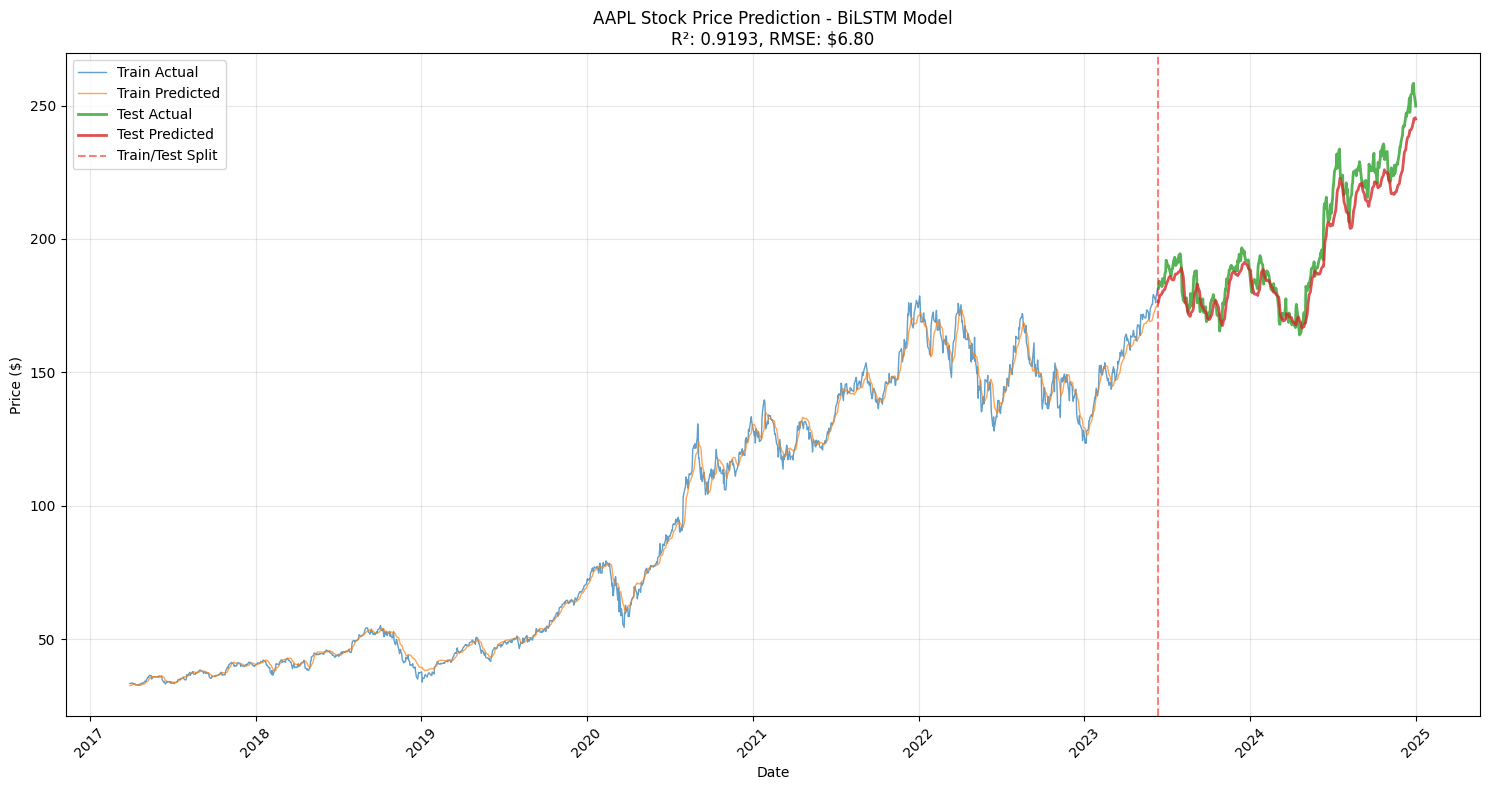

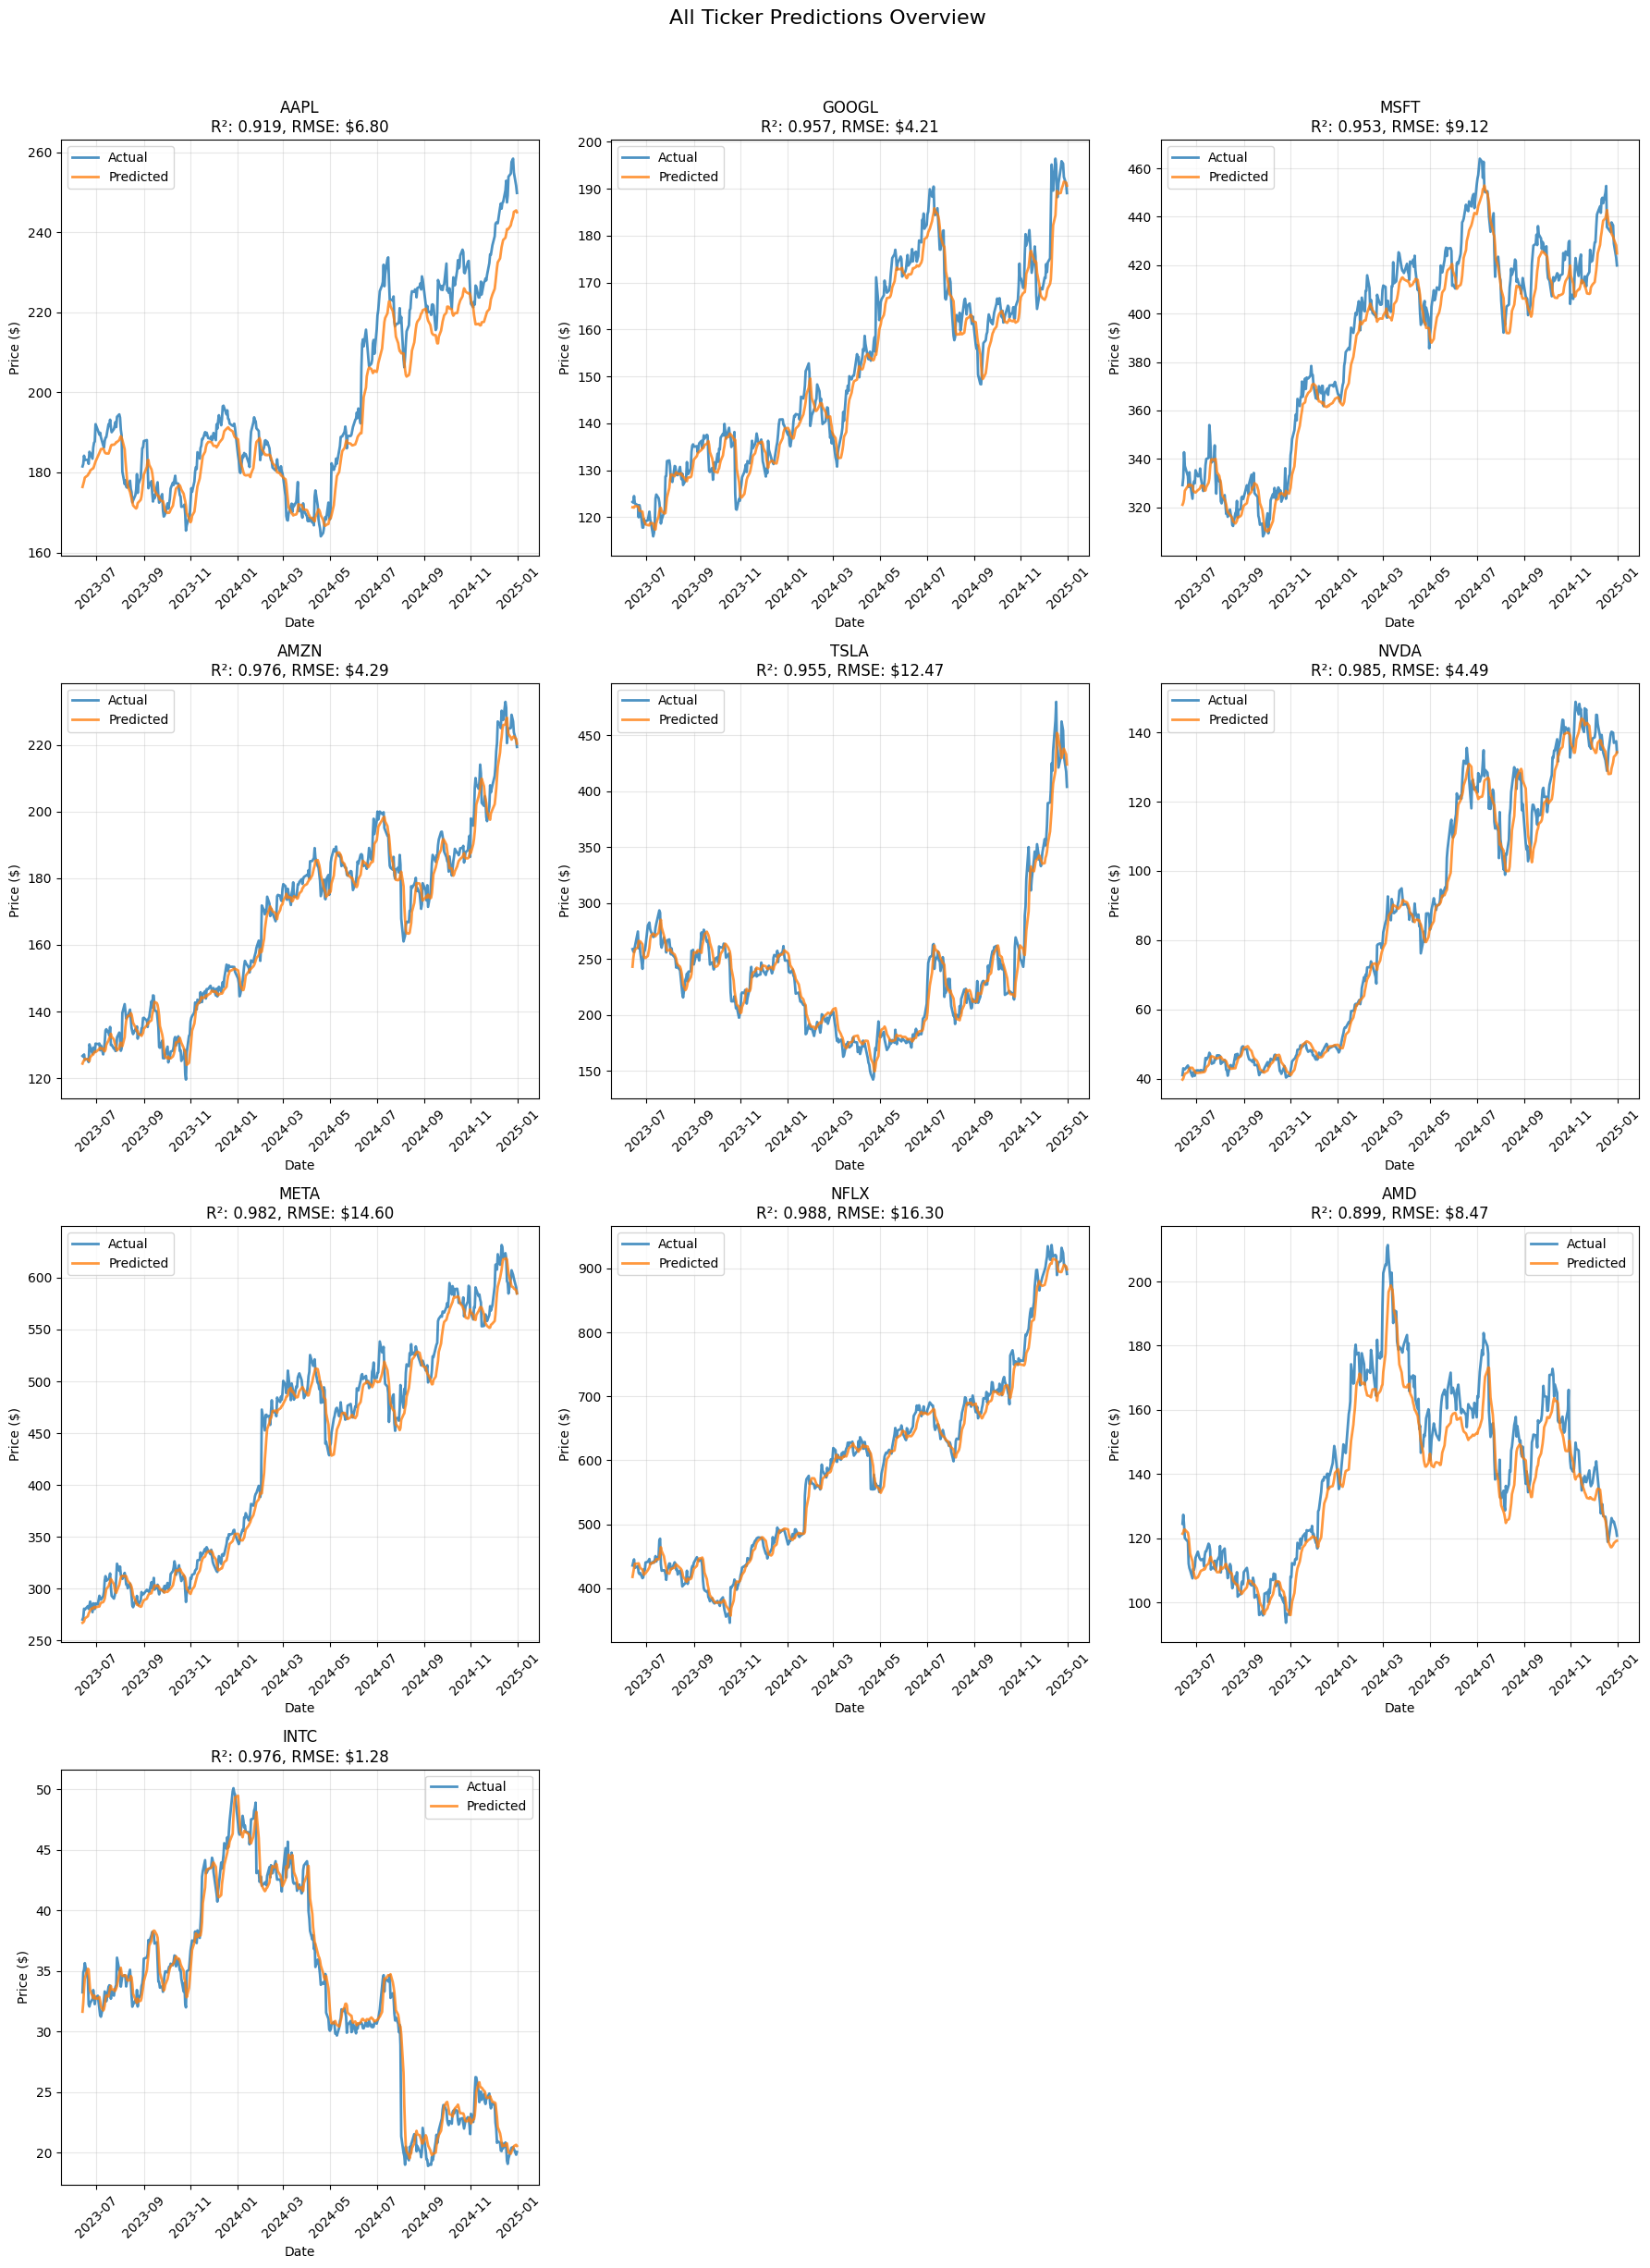

In [7]:
def plot_ticker_prediction(ticker):
   
    if ticker not in metrics:
        print(f"No trained model found for {ticker}")
        return
    
    metrics_data = metrics[ticker]
    data = metrics_data['data']
    predictions = metrics_data['predictions']
    
    plt.figure(figsize=(15, 8))
    
    
    train_size = len(predictions['train_actual'])
    test_size = len(predictions['test_actual'])
    
    train_dates = data.index[SEQUENCE_LENGTH:SEQUENCE_LENGTH + train_size]
    test_dates = data.index[SEQUENCE_LENGTH + train_size:SEQUENCE_LENGTH + train_size + test_size]
    
    plt.plot(train_dates, predictions['train_actual'], label='Train Actual', alpha=0.7, linewidth=1)
    plt.plot(train_dates, predictions['train_pred'], label='Train Predicted', alpha=0.7, linewidth=1)
    plt.plot(test_dates, predictions['test_actual'], label='Test Actual', alpha=0.8, linewidth=2)
    plt.plot(test_dates, predictions['test_pred'], label='Test Predicted', alpha=0.8, linewidth=2)
    plt.axvline(x=test_dates[0], color='red', linestyle='--', alpha=0.5, label='Train/Test Split')
    
    plt.title(f'{ticker} Stock Price Prediction - BiLSTM Model\nR²: {metrics_data["test_r2"]:.4f}, RMSE: ${metrics_data["test_rmse"]:.2f}')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


if successful_tickers:
    example_ticker = successful_tickers[0]  # Plot first successful ticker
    print(f"Plotting prediction for {example_ticker}:")
    plot_ticker_prediction(example_ticker)



# Visualization 
if successful_tickers:

    cols = 3
    rows = (len(successful_tickers) + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(18, 6*rows))
    
   
    if rows == 1:
        axes = [axes] if cols == 1 else axes
    else:
        axes = axes.flatten()
    
    for i, ticker in enumerate(successful_tickers):
        ax = axes[i]
        metrics_data = metrics[ticker]
        data = metrics_data['data']
        predictions = metrics_data['predictions']
        
        train_size = len(predictions['train_actual'])
        test_size = len(predictions['test_actual'])
        test_dates = data.index[SEQUENCE_LENGTH + train_size:SEQUENCE_LENGTH + train_size + test_size]
        
        ax.plot(test_dates, predictions['test_actual'], label='Actual', alpha=0.8, linewidth=2)
        ax.plot(test_dates, predictions['test_pred'], label='Predicted', alpha=0.8, linewidth=2)
        
        ax.set_title(f'{ticker}\nR²: {metrics_data["test_r2"]:.3f}, RMSE: ${metrics_data["test_rmse"]:.2f}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Price ($)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
    
    # Hide empty subplots
    for i in range(len(successful_tickers), len(axes)):
        axes[i].set_visible(False)
    
    plt.suptitle('All Ticker Predictions Overview', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()


In [16]:
if successful_tickers:
    MODEL_DIR = "trained_stock_models"
    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR)
    
    print(f"💾 Saving models to {MODEL_DIR}/")
    print("-" * 40)
    

    for ticker in successful_tickers:
        try:
           
            model_path = f"{MODEL_DIR}/{ticker}_model.h5"
            models[ticker].save(model_path)
            

            scaler_path = f"{MODEL_DIR}/{ticker}_scaler.pkl"
            with open(scaler_path, 'wb') as f:
                pickle.dump(scalers[ticker], f)
            
            print(f" {ticker}: Model and scaler saved")
            
        except Exception as e:
            print(f" {ticker}: Failed to save - {str(e)}")
    
   
    config_data = {
        'sequence_length': SEQUENCE_LENGTH,
        'train_split': TRAIN_SPLIT,
        'epochs': EPOCHS,
        'batch_size': BATCH_SIZE,
        'successful_tickers': successful_tickers,
        'failed_tickers': failed_tickers,
        'metrics': {ticker: {k: v for k, v in metrics[ticker].items() 
                           if k != 'data' and k != 'predictions'} 
                   for ticker in successful_tickers}
    }
    
    with open(f"{MODEL_DIR}/training_config.pkl", 'wb') as f:
        pickle.dump(config_data, f)
    
  
    with open(f"{MODEL_DIR}/ticker_list.txt", 'w') as f:
        f.write('\n'.join(successful_tickers))
    
    print(f"\n All models saved successfully!")
    print(f" Directory: {MODEL_DIR}/")
    print(f" Files saved:")
    print(f"   - {len(successful_tickers)} model files (.h5)")
    print(f"   - {len(successful_tickers)} scaler files (.pkl)")
    print(f"   - training_config.pkl")
    print(f"   - ticker_list.txt")
    
    
else:
    print(" No successful models to save!")


💾 Saving models to trained_stock_models/
----------------------------------------


✅ AAPL: Model and scaler saved


✅ GOOGL: Model and scaler saved
✅ MSFT: Model and scaler saved


✅ AMZN: Model and scaler saved
✅ TSLA: Model and scaler saved


✅ NVDA: Model and scaler saved


✅ META: Model and scaler saved
✅ NFLX: Model and scaler saved
✅ AMD: Model and scaler saved
✅ INTC: Model and scaler saved

✅ All models saved successfully!
📁 Directory: trained_stock_models/
📋 Files saved:
   - 10 model files (.h5)
   - 10 scaler files (.pkl)
   - training_config.pkl
   - ticker_list.txt
